In [56]:
import numpy as np
import pandas as pd

import os
import subprocess
import csv

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import struct
from tqdm import tqdm
import time

In [58]:
def tissue_parameters (nm, **kwargs):
    
    """
    Calculate tissue optical properties based on wavelength and table data spectralLIB.csv

    Parameters:
    nm: int or float
        Wavelength in nm
    **kwargs: dict
        Dictionary of tissue-related parameters.

    Returns:
    dict
        Tissue parameters for the given wavelength.
    """
    #Set default values for parameters
    Cmel_melanoma = kwargs.get("Cmel_melanoma", 0.1)            # Fraction of melanin in melanoma
    blood_vol = kwargs.get("blood_vol", 0.005)                  # Fraction of blood in melanoma
    oxygen_sat = kwargs.get("oxygen_sat", 0.65)                 # Fraction of blood oxygen in melanoma
    musp500_mel = kwargs.get("musp500_mel", 40)                 
    bmie_mel = kwargs.get("bmie_mel", 1)
    gg_mel = kwargs.get("gg_mel", 0.8)
    
    escale = 10 # going from cm-1 to mm-1

    #Download spectral data 
    data = pd.read_csv('spectralLIB.csv')
    nmLIB = data['Wavelength'].values
    columns = ['muaoxy', 'muadeoxy', 'muawater', 'muamel']
    MU = np.array([np.interp(nm, nmLIB, data[col].values) / escale for col in columns])
        
    # Create tissueList
    tissue_list = {}
    
      # air
    tissue_list[1] = {'name': 'air', 'mua': 0.0001, 'mus': 1.0, 'g': 1.0}
    
      # epidermis
    B = 0.0
    S = 0.0
    W = 0.2
    M = 0.02
    musp500 = 71.24
    fray = 0
    bmie = 3.543
    gg = 0.95
    musp = (musp500 * (fray * (nm/500) ** -4 + (1 - fray) * (nm/500) ** -bmie))/escale
    X = np.array([B*S, B*(1-S), W, M])
    tissue_list[2] = {'name': 'epidermis', 'mua': np.dot(MU, X), 'mus': musp/(1-gg), 'g': gg}
    
      # dermis
    B = 0.005619375
    S = 0.56
    W = 0.85
    M = 0
    musp500 = 69.11
    fray = 0
    bmie = 3.45
    gg = 0.95
    musp = (musp500 * (fray * (nm/500) ** -4 + (1 - fray) * (nm/500) ** -bmie))/escale
    X = np.array([B*S, B*(1-S), W, M])
    tissue_list[3] = {'name': 'dermis', 'mua': np.dot(MU, X), 'mus': musp/(1-gg), 'g': gg}
    
      
      # melanoma
    B = blood_vol
    S = oxygen_sat
    W = 0.75
    M = Cmel_melanoma
    musp500 = musp500_mel
    fray = 0
    bmie = bmie_mel
    gg = gg_mel
    musp = (musp500 * (fray * (nm/500) ** -4 + (1 - fray) * (nm/500) ** -bmie))/escale
    X = np.array([B*S, B*(1-S), W, M])
    tissue_list[4] = {'name': 'melanoma', 'mua': np.dot(MU, X), 'mus': musp/(1-gg), 'g': gg}
               
    return tissue_list 
tissue_parameters (500)

{1: {'name': 'air', 'mua': 0.0001, 'mus': 1.0, 'g': 1.0},
 2: {'name': 'epidermis',
  'mua': 1.358325,
  'mus': 142.47999999999988,
  'g': 0.95},
 3: {'name': 'dermis',
  'mua': 0.06291620022185249,
  'mus': 138.21999999999986,
  'g': 0.95},
 4: {'name': 'melanoma',
  'mua': 6.847598395553513,
  'mus': 20.000000000000004,
  'g': 0.8}}

In [60]:
#dark melanoma

file_path = 'dark_mouse1_left.xlsx'
#/Users/vasilielen/Desktop/melanoma_studies/experiments brasilian
df_exp = pd.read_excel(file_path)
x = df_exp.iloc[:, 0]
M1tl = df_exp.iloc[:, 1]/100


In [62]:
T=np.load('T_updated.npy')
T=np.repeat(T[:, :, np.newaxis], 400, axis=2)


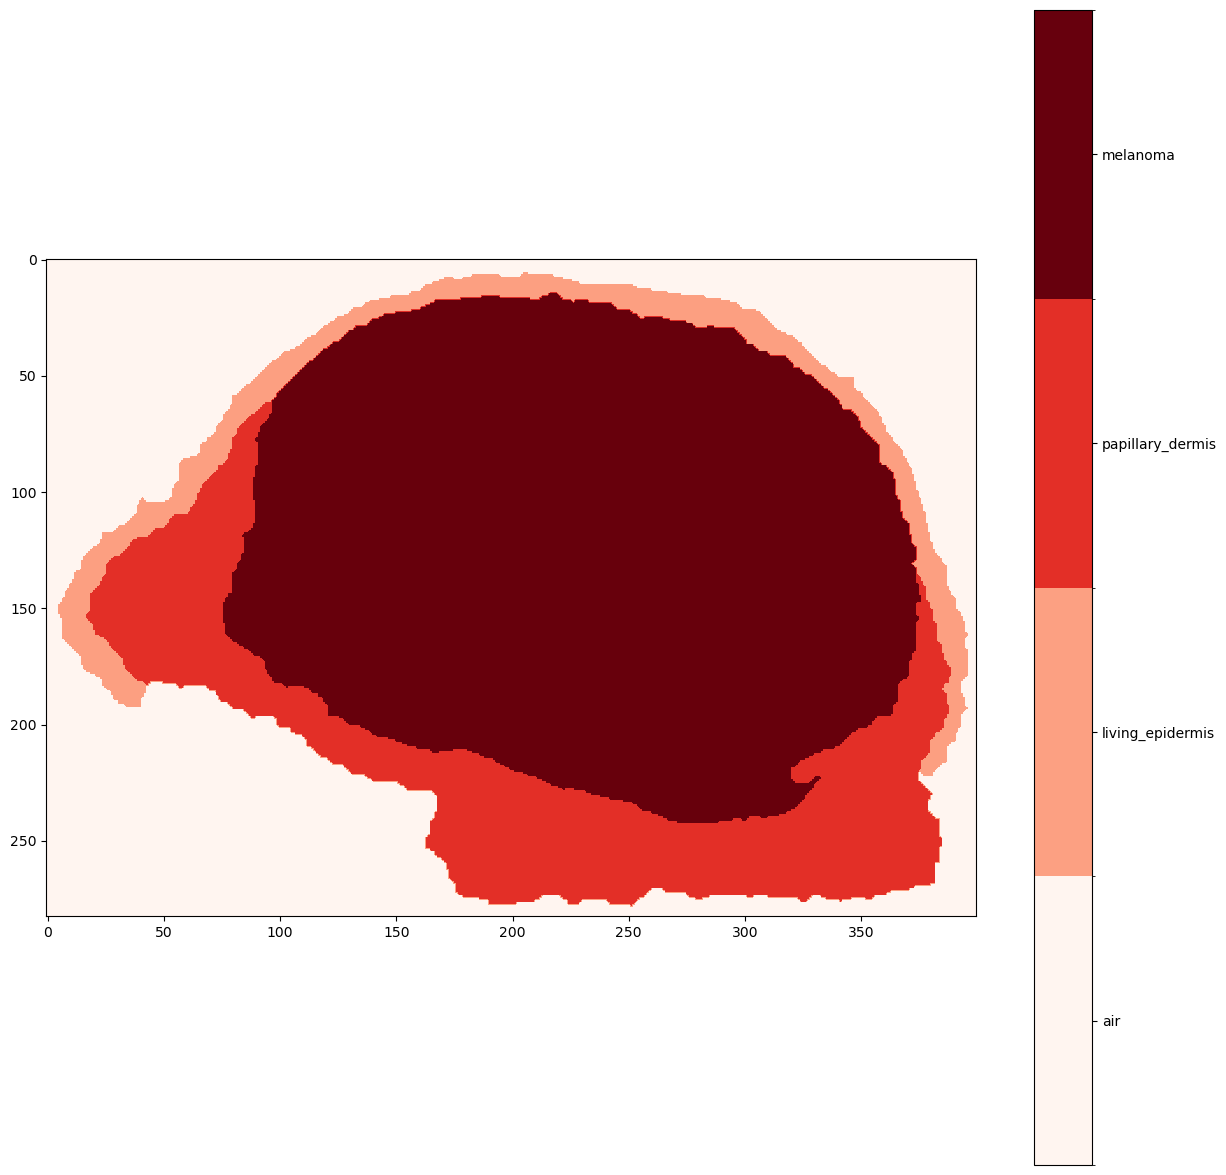

In [64]:
tissue_dict = {
    1: "air",
    2: "living_epidermis",
    3: "papillary_dermis",
    4: 'melanoma'
}

fig, ax = plt.subplots(figsize=(15, 15))

cmap = plt.get_cmap('Reds', len(tissue_dict))
norm = mcolors.BoundaryNorm(boundaries=np.arange(1, len(tissue_dict)+2)-0.5, ncolors=len(tissue_dict))

im = ax.imshow(T[:,:,100], cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks(np.arange(1, len(tissue_dict) + 1))
cbar.set_ticklabels([tissue_dict[i] for i in range(1, len(tissue_dict) + 1)])

In [66]:
myname = 'melanoma'   # name for files: myname_T.bin, myname_H.mci
time_min = 1          # time duration of the simulation [min]
binsize = 0.013363    # size of each bin, eg. [mm] 
NBINS = 400           # number of bins in each dimension of cube

# Simulation flags
mcflag = 1        # launch: 0 = uniform beam, 1 = Gaussian, 2 = isotropic pt., 3 = rectangular beam (use xfocus,yfocus for x,y halfwidths), 4 - point source
launchflag = 0    # 0 = let mcxyz.c calculate launch trajectory, 1 = manually set launch vector.
boundaryflag = 2  # 0 = no boundaries, 1 = escape at boundaries, 2 = escape at surface only. No x, y, bottom z boundaries
mckernelflag = 1  # 0 - mcsub, 1 - mcxyz, 2 - neural mc
zsurf = 0.0       # position of air/skin surface
accuracyflag = 1  # 0 == 50000 photons, 1==100000 photons

lc = 0.0;
na = 90.0
speckleflag = 0;
semiflag = 0;
det_state = 0;

# Source and focus settings
xs, ys  = 0.0, 0.0                       # point of source, zs is used as parameter further 
xfocus, yfocus, zfocus = 0, 0, 10**12    # position of focus. Set position of focus, so mcxyz can calculate launch trajectory
  # only used if mcflag == 0 or 1 or 3 (not 2=isotropic pt.)
radius = 0.4                            # 1/e radius of beam at tissue surface (FWHM?)
detector_radius = 0.4 # size of probe in mm
separation = 0.42     # space between fibers      

waist = radius                             # 1/e radius of beam at focus
  # only used if launchflag == 1 (manually set launch trajectory)
ux0 = 0.7                                # trajectory projected onto x axis
uy0 = 0.4                                # trajectory projected onto y axis
uz0 = np.sqrt(1 - ux0**2 - uy0**2)       # such that ux^2 + uy^2 + uz^2 = 1

# Prepare for runs
  # useful for understanding what the parameters are: https://iopscience.iop.org/article/10.1088/0031-9155/58/11/R37

n1, n2 = 1.4, 1.0                        # refractive index of inside (1) and outside (2) medium 
dx = dy = dz = binsize                   # bin size for runs [mm]
Ny = Nz = NBINS       
Nx=283 # cube size for runs [mm]

In [68]:
def nmc_spectra(nm_start, nm_end, step, **params):
    """
    Simulate one spectrum line using NMC for a range of wavelengths.
    
    Parameters:
    nm_start: int
        Starting wavelength.
    nm_end: int
        Ending wavelength.
    step: int
        Step size for wavelength.
    **params: dict
        Dictionary of parameters for tissue and simulation.
    
    Returns:
    tuple
        nms: list of wavelengths
        rd_list: list of reflectance data
    """
    # Set default values for the parameters
    r = params.get("r", -1)                                     # Radius of melanoma
    zs = params.get("zs", 0.0)                                  # height for point of source   
    
            
    rd_list = []
    nms = np.arange(nm_start, nm_end, step)                     # Wavelengths of the source
    
    for nm in tqdm(nms):
        
        # Get tissue parameters for the current wavelength
        tp = tissue_parameters (nm, **params)
        print(nm, ", ".join(f"{k}={v}" for k, v in params.items()))
        
        # Run Simulation
        #T = make_tissue(r_mel=r)
        
        v = T.astype(np.uint8).flatten()
        
        # Write .mci file
        filename = f"{myname}_H.mci"
        with open(filename, 'w') as file:
            file.write(f"{time_min:.2f}\n{Nx}\n{Ny}\n{Nz}\n{dx:.4f}\n{dy:.4f}\n{dz:.4f}\n")
            file.write(f"{mcflag}\n{launchflag}\n{boundaryflag}\n{xs:.4f}\n{ys:.4f}\n{zs:.4f}\n")
            file.write(f"{xfocus:.4f}\n{yfocus:.4f}\n{zfocus:.4f}\n{ux0:.4f}\n{uy0:.4f}\n{uz0:.4f}\n")
            file.write(f"{radius:.4f}\n{waist:.4f}\n{zsurf:.4f}\n{detector_radius:.4f}\n{separation:.4f}\n{n1:.4f}\n{n2:.4f}\n{na:.4f}\n{nm:.4f}\n{lc:.4f}\n")
            file.write(f"{speckleflag}\n{semiflag}\n{det_state}\n{mckernelflag}\n")
            file.write(f"{len(tp)}\n")
            
            for i in range(len(tp)):
                mua_i, mus_i, g_i = tp[i+1]["mua"], tp[i+1]["mus"], tp[i+1]["g"]  # n1
                file.write(f"{mua_i:.4f}\n{mus_i:.4f}\n{g_i:.4f}\n")
        
        # Write .bin file
        bin_filename = f"{myname}_T.bin"
        with open(bin_filename, 'wb') as file:
            file.write(v.tobytes())
        
        # Run NMC simulation
        with subprocess.Popen(["./nmc", myname], stdout=subprocess.PIPE, stderr=subprocess.PIPE) as proc:
            try:
                stdout, stderr = proc.communicate(timeout=300)  # Set a timeout if needed
                #print("Output:", stdout.decode())
            except subprocess.TimeoutExpired:
                proc.kill()  # Ensure the process is killed if it times out
                print("Process timed out and was terminated.")
        
        # Read and store reflectance data
        rd = np.loadtxt(f"{myname}_Rd.dat")
        rd_list.append(rd)
    
    return nms, rd_list

In [84]:
params = {
   # "r": 1,
    "zs": 0.1,
    "Cmel_melanoma": 0.6653,
    "blood_vol": 0.1,
    "oxygen_sat": 0.6,
    "musp500_mel" : 66.64,
    "bmie_mel" : 1,
    "gg_mel" : 0.2
}

start_time = time.time() 
nms, rd_list = nmc_spectra(450, 900, 15, **params)
end_time = time.time()
execution_time=end_time-start_time

  0%|                                                    | 0/30 [00:00<?, ?it/s]

450 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


  3%|█▍                                          | 1/30 [00:02<01:10,  2.43s/it]

465 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


  7%|██▉                                         | 2/30 [00:04<01:07,  2.42s/it]

480 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 10%|████▍                                       | 3/30 [00:07<01:02,  2.32s/it]

495 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 13%|█████▊                                      | 4/30 [00:09<00:57,  2.20s/it]

510 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 17%|███████▎                                    | 5/30 [00:11<00:55,  2.22s/it]

525 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 20%|████████▊                                   | 6/30 [00:13<00:54,  2.28s/it]

540 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 23%|██████████▎                                 | 7/30 [00:15<00:51,  2.24s/it]

555 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 27%|███████████▋                                | 8/30 [00:18<00:50,  2.28s/it]

570 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 30%|█████████████▏                              | 9/30 [00:19<00:44,  2.11s/it]

585 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 33%|██████████████▎                            | 10/30 [00:22<00:46,  2.33s/it]

600 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 37%|███████████████▊                           | 11/30 [00:24<00:41,  2.21s/it]

615 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 40%|█████████████████▏                         | 12/30 [00:27<00:43,  2.40s/it]

630 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 43%|██████████████████▋                        | 13/30 [00:29<00:39,  2.35s/it]

645 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 47%|████████████████████                       | 14/30 [00:32<00:38,  2.43s/it]

660 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 50%|█████████████████████▌                     | 15/30 [00:34<00:34,  2.29s/it]

675 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 53%|██████████████████████▉                    | 16/30 [00:37<00:33,  2.39s/it]

690 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 57%|████████████████████████▎                  | 17/30 [00:39<00:33,  2.54s/it]

705 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 60%|█████████████████████████▊                 | 18/30 [00:42<00:31,  2.60s/it]

720 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 63%|███████████████████████████▏               | 19/30 [00:44<00:26,  2.40s/it]

735 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 67%|████████████████████████████▋              | 20/30 [00:47<00:25,  2.55s/it]

750 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 70%|██████████████████████████████             | 21/30 [00:50<00:25,  2.80s/it]

765 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 73%|███████████████████████████████▌           | 22/30 [00:53<00:20,  2.62s/it]

780 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 77%|████████████████████████████████▉          | 23/30 [00:55<00:18,  2.71s/it]

795 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 80%|██████████████████████████████████▍        | 24/30 [00:58<00:16,  2.70s/it]

810 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 83%|███████████████████████████████████▊       | 25/30 [01:02<00:14,  2.95s/it]

825 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 87%|█████████████████████████████████████▎     | 26/30 [01:05<00:12,  3.02s/it]

840 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 90%|██████████████████████████████████████▋    | 27/30 [01:08<00:09,  3.08s/it]

855 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 93%|████████████████████████████████████████▏  | 28/30 [01:11<00:06,  3.03s/it]

870 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


 97%|█████████████████████████████████████████▌ | 29/30 [01:14<00:03,  3.01s/it]

885 zs=0.1, Cmel_melanoma=0.6653, blood_vol=0.1, oxygen_sat=0.6, musp500_mel=66.64, bmie_mel=1, gg_mel=0.2


100%|███████████████████████████████████████████| 30/30 [01:17<00:00,  2.59s/it]


Execution time: 77.67 seconds


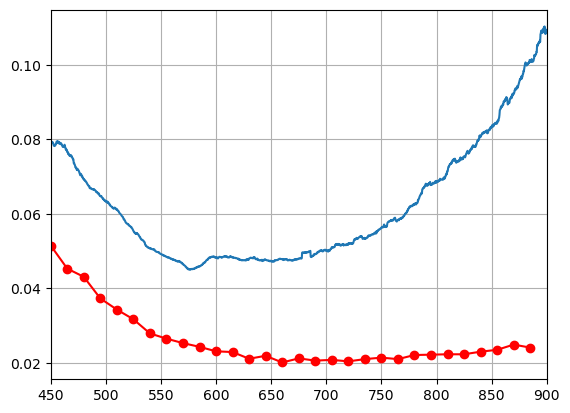

In [86]:
print(f"Execution time: {execution_time:.2f} seconds")
plt.figure(1) 
plt.plot(nms, np.array(rd_list), 'o-', color = 'red')
#plt.ylim([0,1])
plt.xlim([450,900])
plt.grid(True)

plt.plot(x, M1tl)

In [94]:
import itertools
from tqdm import tqdm

# Define the range or list of values for each parameter
params_range = {
    'zs_values': np.arange(0.0, 0.2, 0.1),
    'Cmel_melanoma_values' : np.arange(0.1, 0.41, 0.1),
    'blood_vol_values' : np.arange(0.1, 0.81, 0.1),
    'oxygen_sat_values' : np.arange(0.67, 0.8, 0.4),
    'gg_mel_values' : np.arange(0.1, 0.81, 0.1),
    #'Cmel_epidermis_values' : np.arange(0.02, 0.03, 0.1),
}
num_iterations = np.prod([len(values) for values in params_range.values()])
print('Number of iterations is', num_iterations)
params_range

Number of iterations is 512


{'zs_values': array([0. , 0.1]),
 'Cmel_melanoma_values': array([0.1, 0.2, 0.3, 0.4]),
 'blood_vol_values': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 'oxygen_sat_values': array([0.67]),
 'gg_mel_values': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])}

In [ ]:
# Create a list to store the results
results = []

def run_nmc_spectra(**params):
    try :
        nms, rd_list = nmc_spectra(450, 920, 25, **params)
        return {
            **params,
            'nms': nms,
            'rd_list': rd_list,
        }
    except Exception as e:
        return {'error': str(e), **params}

# Use itertools.product to create combinations of the parameters
param_combinations = [
    dict(zip(params_range.keys(), values))
    for values in itertools.product(*params_range.values())
]

# Define a function to save results to a CSV 
def save_to_csv(file_name, nms, rd_list, params, clear=False):
    # Prepare the mode: clear file if specified, otherwise append
    mode = 'w' if clear else 'a'
    
    # Open the CSV file
    with open(file_name, mode, newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write the header if clearing the file
        if clear:
            header = ['nms', 'rd_list'] + list(params.keys())
            writer.writerow(header)
        
        # Write the data row by row
        for nm, rd in zip(nms, rd_list):
            row = [nm, rd] + list(params.values())
            writer.writerow(row)


# File to save results
output_file = "brasil_exp_results.csv"

# Process each combination sequentially with a progress bar
for idx, params in enumerate(tqdm(param_combinations, desc="Processing")):
    result = run_nmc_spectra(**params)
    if 'error' in result:
        print(f"Error for params {params}: {result['error']}")
    else:
        # Save every 10 spectra to the CSV
        save_to_csv(
            output_file,
            result['nms'],
            result['rd_list'],
            {k: v for k, v in params.items()},
            clear=(idx == 0)  # Clear the file only at the beginning
        )

  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



  5%|██▎                                         | 1/19 [00:02<00:52,  2.89s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 11%|████▋                                       | 2/19 [00:06<00:57,  3.36s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 16%|██████▉                                     | 3/19 [00:09<00:54,  3.38s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 21%|█████████▎                                  | 4/19 [00:12<00:44,  2.94s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 26%|███████████▌                                | 5/19 [00:16<00:45,  3.26s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 32%|█████████████▉                              | 6/19 [00:19<00:45,  3.47s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 37%|████████████████▏                           | 7/19 [00:23<00:40,  3.41s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 42%|██████████████████▌                         | 8/19 [00:26<00:38,  3.48s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 47%|████████████████████▊                       | 9/19 [00:30<00:35,  3.59s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 53%|██████████████████████▋                    | 10/19 [00:34<00:33,  3.73s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 58%|████████████████████████▉                  | 11/19 [00:38<00:30,  3.87s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.05s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 68%|█████████████████████████████▍             | 13/19 [00:48<00:26,  4.38s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.83s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 79%|█████████████████████████████████▉         | 15/19 [01:00<00:21,  5.33s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.79s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.24s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



 95%|████████████████████████████████████████▋  | 18/19 [01:22<00:06,  6.58s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.1



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



  5%|██▎                                         | 1/19 [00:03<01:08,  3.79s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 11%|████▋                                       | 2/19 [00:06<00:57,  3.39s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 16%|██████▉                                     | 3/19 [00:10<00:54,  3.38s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 21%|█████████▎                                  | 4/19 [00:14<00:54,  3.62s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 26%|███████████▌                                | 5/19 [00:17<00:51,  3.65s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 32%|█████████████▉                              | 6/19 [00:20<00:43,  3.35s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 37%|████████████████▏                           | 7/19 [00:24<00:42,  3.53s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 42%|██████████████████▌                         | 8/19 [00:28<00:39,  3.62s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 47%|████████████████████▊                       | 9/19 [00:32<00:37,  3.78s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 53%|██████████████████████▋                    | 10/19 [00:36<00:34,  3.85s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 58%|████████████████████████▉                  | 11/19 [00:40<00:31,  3.99s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 63%|███████████████████████████▏               | 12/19 [00:45<00:29,  4.22s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 68%|█████████████████████████████▍             | 13/19 [00:50<00:27,  4.53s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 74%|███████████████████████████████▋           | 14/19 [00:56<00:24,  4.92s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 79%|█████████████████████████████████▉         | 15/19 [01:03<00:21,  5.42s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 84%|████████████████████████████████████▏      | 16/19 [01:10<00:17,  5.93s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 89%|██████████████████████████████████████▍    | 17/19 [01:17<00:12,  6.33s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



 95%|████████████████████████████████████████▋  | 18/19 [01:25<00:06,  6.70s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.2



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



  5%|██▎                                         | 1/19 [00:02<00:49,  2.76s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 11%|████▋                                       | 2/19 [00:06<00:57,  3.36s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 16%|██████▉                                     | 3/19 [00:09<00:52,  3.27s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 21%|█████████▎                                  | 4/19 [00:13<00:52,  3.49s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 26%|███████████▌                                | 5/19 [00:16<00:47,  3.36s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 32%|█████████████▉                              | 6/19 [00:19<00:42,  3.30s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 37%|████████████████▏                           | 7/19 [00:23<00:40,  3.34s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 42%|██████████████████▌                         | 8/19 [00:27<00:38,  3.49s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 47%|████████████████████▊                       | 9/19 [00:30<00:33,  3.40s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 53%|██████████████████████▋                    | 10/19 [00:34<00:32,  3.59s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 58%|████████████████████████▉                  | 11/19 [00:38<00:30,  3.79s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.01s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 68%|█████████████████████████████▍             | 13/19 [00:48<00:26,  4.44s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.87s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 79%|█████████████████████████████████▉         | 15/19 [01:00<00:21,  5.37s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.85s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.30s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 95%|████████████████████████████████████████▋  | 18/19 [01:22<00:06,  6.61s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



  5%|██▎                                         | 1/19 [00:03<00:59,  3.33s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 11%|████▋                                       | 2/19 [00:06<00:52,  3.07s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 16%|██████▉                                     | 3/19 [00:09<00:47,  2.99s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 21%|█████████▎                                  | 4/19 [00:12<00:47,  3.14s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 26%|███████████▌                                | 5/19 [00:15<00:45,  3.26s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 32%|█████████████▉                              | 6/19 [00:19<00:44,  3.39s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 37%|████████████████▏                           | 7/19 [00:22<00:39,  3.33s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 42%|██████████████████▌                         | 8/19 [00:26<00:37,  3.42s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 47%|████████████████████▊                       | 9/19 [00:30<00:35,  3.58s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 53%|██████████████████████▋                    | 10/19 [00:34<00:33,  3.73s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 58%|████████████████████████▉                  | 11/19 [00:38<00:30,  3.87s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.10s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 68%|█████████████████████████████▍             | 13/19 [00:48<00:26,  4.46s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.89s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 79%|█████████████████████████████████▉         | 15/19 [01:00<00:21,  5.38s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.87s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.31s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



 95%|████████████████████████████████████████▋  | 18/19 [01:22<00:06,  6.62s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.4



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



  5%|██▎                                         | 1/19 [00:02<00:52,  2.89s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 11%|████▋                                       | 2/19 [00:05<00:49,  2.92s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 16%|██████▉                                     | 3/19 [00:09<00:50,  3.14s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 21%|█████████▎                                  | 4/19 [00:12<00:49,  3.30s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 26%|███████████▌                                | 5/19 [00:15<00:45,  3.25s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 32%|█████████████▉                              | 6/19 [00:19<00:43,  3.37s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 37%|████████████████▏                           | 7/19 [00:23<00:41,  3.46s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 42%|██████████████████▌                         | 8/19 [00:27<00:39,  3.59s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 47%|████████████████████▊                       | 9/19 [00:31<00:37,  3.73s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 53%|██████████████████████▋                    | 10/19 [00:35<00:34,  3.85s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 58%|████████████████████████▉                  | 11/19 [00:39<00:31,  3.98s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.13s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 68%|█████████████████████████████▍             | 13/19 [00:49<00:26,  4.46s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 74%|███████████████████████████████▋           | 14/19 [00:55<00:24,  4.91s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 79%|█████████████████████████████████▉         | 15/19 [01:01<00:21,  5.39s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 84%|████████████████████████████████████▏      | 16/19 [01:08<00:17,  5.92s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 89%|██████████████████████████████████████▍    | 17/19 [01:16<00:12,  6.32s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



 95%|████████████████████████████████████████▋  | 18/19 [01:23<00:06,  6.64s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.5



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



  5%|██▎                                         | 1/19 [00:02<00:45,  2.52s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 11%|████▋                                       | 2/19 [00:05<00:47,  2.77s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 16%|██████▉                                     | 3/19 [00:08<00:47,  2.97s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 21%|█████████▎                                  | 4/19 [00:11<00:45,  3.01s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 26%|███████████▌                                | 5/19 [00:15<00:44,  3.20s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 32%|█████████████▉                              | 6/19 [00:18<00:40,  3.14s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 37%|████████████████▏                           | 7/19 [00:21<00:37,  3.16s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 42%|██████████████████▌                         | 8/19 [00:25<00:36,  3.33s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 47%|████████████████████▊                       | 9/19 [00:29<00:35,  3.56s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 53%|██████████████████████▋                    | 10/19 [00:33<00:33,  3.72s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 58%|████████████████████████▉                  | 11/19 [00:37<00:31,  3.89s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 63%|███████████████████████████▏               | 12/19 [00:42<00:28,  4.12s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 68%|█████████████████████████████▍             | 13/19 [00:47<00:26,  4.48s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 74%|███████████████████████████████▋           | 14/19 [00:53<00:24,  4.91s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 79%|█████████████████████████████████▉         | 15/19 [00:59<00:21,  5.39s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.88s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 89%|██████████████████████████████████████▍    | 17/19 [01:14<00:12,  6.31s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 95%|████████████████████████████████████████▋  | 18/19 [01:21<00:06,  6.64s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



  5%|██▎                                         | 1/19 [00:02<00:47,  2.66s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 11%|████▋                                       | 2/19 [00:05<00:50,  2.98s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 16%|██████▉                                     | 3/19 [00:09<00:51,  3.21s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 21%|█████████▎                                  | 4/19 [00:12<00:48,  3.21s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 26%|███████████▌                                | 5/19 [00:15<00:44,  3.20s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 32%|█████████████▉                              | 6/19 [00:19<00:42,  3.27s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 37%|████████████████▏                           | 7/19 [00:22<00:39,  3.32s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 42%|██████████████████▌                         | 8/19 [00:26<00:37,  3.39s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 47%|████████████████████▊                       | 9/19 [00:30<00:35,  3.59s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 53%|██████████████████████▋                    | 10/19 [00:34<00:33,  3.77s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 58%|████████████████████████▉                  | 11/19 [00:38<00:31,  3.93s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 63%|███████████████████████████▏               | 12/19 [00:43<00:29,  4.20s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 68%|█████████████████████████████▍             | 13/19 [00:48<00:26,  4.44s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.91s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 79%|█████████████████████████████████▉         | 15/19 [01:00<00:21,  5.41s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.87s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.32s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 95%|████████████████████████████████████████▋  | 18/19 [01:22<00:06,  6.64s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



  5%|██▎                                         | 1/19 [00:02<00:50,  2.81s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 11%|████▋                                       | 2/19 [00:06<00:56,  3.31s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 16%|██████▉                                     | 3/19 [00:09<00:52,  3.27s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 21%|█████████▎                                  | 4/19 [00:12<00:47,  3.16s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 26%|███████████▌                                | 5/19 [00:15<00:43,  3.10s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 32%|█████████████▉                              | 6/19 [00:19<00:43,  3.36s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 37%|████████████████▏                           | 7/19 [00:23<00:41,  3.43s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 42%|██████████████████▌                         | 8/19 [00:27<00:39,  3.59s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 47%|████████████████████▊                       | 9/19 [00:30<00:36,  3.67s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 53%|██████████████████████▋                    | 10/19 [00:35<00:34,  3.81s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 58%|████████████████████████▉                  | 11/19 [00:39<00:31,  3.96s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.13s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 68%|█████████████████████████████▍             | 13/19 [00:48<00:26,  4.43s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.86s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 79%|█████████████████████████████████▉         | 15/19 [01:01<00:21,  5.35s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 84%|████████████████████████████████████▏      | 16/19 [01:08<00:17,  5.87s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.32s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



 95%|████████████████████████████████████████▋  | 18/19 [01:23<00:06,  6.67s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.1, oxygen_sat_values=0.67, gg_mel_values=0.8



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



  5%|██▎                                         | 1/19 [00:02<00:46,  2.56s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 11%|████▋                                       | 2/19 [00:05<00:47,  2.80s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 16%|██████▉                                     | 3/19 [00:08<00:47,  2.95s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 21%|█████████▎                                  | 4/19 [00:11<00:45,  3.04s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 26%|███████████▌                                | 5/19 [00:15<00:43,  3.11s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 32%|█████████████▉                              | 6/19 [00:19<00:44,  3.39s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 37%|████████████████▏                           | 7/19 [00:22<00:42,  3.58s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 42%|██████████████████▌                         | 8/19 [00:26<00:40,  3.69s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 47%|████████████████████▊                       | 9/19 [00:30<00:36,  3.67s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 53%|██████████████████████▋                    | 10/19 [00:34<00:34,  3.81s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 58%|████████████████████████▉                  | 11/19 [00:38<00:31,  3.93s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.12s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 68%|█████████████████████████████▍             | 13/19 [00:48<00:27,  4.52s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.97s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 79%|█████████████████████████████████▉         | 15/19 [01:01<00:21,  5.42s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 84%|████████████████████████████████████▏      | 16/19 [01:08<00:17,  5.88s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.31s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



 95%|████████████████████████████████████████▋  | 18/19 [01:22<00:06,  6.63s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.1



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



  5%|██▎                                         | 1/19 [00:02<00:53,  2.99s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 11%|████▋                                       | 2/19 [00:06<01:00,  3.53s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 16%|██████▉                                     | 3/19 [00:09<00:52,  3.27s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 21%|█████████▎                                  | 4/19 [00:12<00:48,  3.22s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 26%|███████████▌                                | 5/19 [00:16<00:47,  3.39s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 32%|█████████████▉                              | 6/19 [00:20<00:45,  3.49s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 37%|████████████████▏                           | 7/19 [00:23<00:41,  3.47s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 42%|██████████████████▌                         | 8/19 [00:27<00:38,  3.46s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 47%|████████████████████▊                       | 9/19 [00:31<00:35,  3.58s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 53%|██████████████████████▋                    | 10/19 [00:35<00:33,  3.77s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 58%|████████████████████████▉                  | 11/19 [00:39<00:31,  3.94s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 63%|███████████████████████████▏               | 12/19 [00:44<00:28,  4.12s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 68%|█████████████████████████████▍             | 13/19 [00:49<00:26,  4.41s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 74%|███████████████████████████████▋           | 14/19 [00:55<00:24,  4.87s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 79%|█████████████████████████████████▉         | 15/19 [01:01<00:21,  5.35s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 84%|████████████████████████████████████▏      | 16/19 [01:08<00:17,  5.81s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 89%|██████████████████████████████████████▍    | 17/19 [01:15<00:12,  6.26s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



 95%|████████████████████████████████████████▋  | 18/19 [01:23<00:06,  6.59s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.2



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



  5%|██▎                                         | 1/19 [00:02<00:46,  2.57s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 11%|████▋                                       | 2/19 [00:05<00:51,  3.02s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 16%|██████▉                                     | 3/19 [00:08<00:45,  2.87s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 21%|█████████▎                                  | 4/19 [00:11<00:43,  2.87s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 26%|███████████▌                                | 5/19 [00:14<00:39,  2.83s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 32%|█████████████▉                              | 6/19 [00:17<00:39,  3.01s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 37%|████████████████▏                           | 7/19 [00:20<00:36,  3.02s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 42%|██████████████████▌                         | 8/19 [00:23<00:33,  3.07s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 47%|████████████████████▊                       | 9/19 [00:27<00:32,  3.29s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 53%|██████████████████████▋                    | 10/19 [00:31<00:31,  3.50s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 58%|████████████████████████▉                  | 11/19 [00:35<00:29,  3.71s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 63%|███████████████████████████▏               | 12/19 [00:40<00:27,  3.96s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 68%|█████████████████████████████▍             | 13/19 [00:45<00:26,  4.34s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 74%|███████████████████████████████▋           | 14/19 [00:51<00:23,  4.76s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 79%|█████████████████████████████████▉         | 15/19 [00:57<00:21,  5.28s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 84%|████████████████████████████████████▏      | 16/19 [01:04<00:17,  5.80s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 89%|██████████████████████████████████████▍    | 17/19 [01:12<00:12,  6.26s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



 95%|████████████████████████████████████████▋  | 18/19 [01:19<00:06,  6.60s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.30000000000000004



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



  5%|██▎                                         | 1/19 [00:02<00:40,  2.23s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 11%|████▋                                       | 2/19 [00:05<00:47,  2.81s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 16%|██████▉                                     | 3/19 [00:08<00:45,  2.85s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 21%|█████████▎                                  | 4/19 [00:11<00:45,  3.06s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 26%|███████████▌                                | 5/19 [00:14<00:42,  3.01s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 32%|█████████████▉                              | 6/19 [00:17<00:38,  2.99s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 37%|████████████████▏                           | 7/19 [00:21<00:38,  3.21s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 42%|██████████████████▌                         | 8/19 [00:25<00:37,  3.42s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 47%|████████████████████▊                       | 9/19 [00:28<00:34,  3.49s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 53%|██████████████████████▋                    | 10/19 [00:32<00:32,  3.66s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 58%|████████████████████████▉                  | 11/19 [00:36<00:30,  3.82s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 63%|███████████████████████████▏               | 12/19 [00:41<00:28,  4.04s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 68%|█████████████████████████████▍             | 13/19 [00:46<00:26,  4.35s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 74%|███████████████████████████████▋           | 14/19 [00:52<00:24,  4.81s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 79%|█████████████████████████████████▉         | 15/19 [00:58<00:21,  5.31s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 84%|████████████████████████████████████▏      | 16/19 [01:05<00:17,  5.83s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 89%|██████████████████████████████████████▍    | 17/19 [01:13<00:12,  6.26s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



 95%|████████████████████████████████████████▋  | 18/19 [01:20<00:06,  6.59s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.4



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



  5%|██▎                                         | 1/19 [00:03<01:00,  3.38s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 11%|████▋                                       | 2/19 [00:06<00:54,  3.22s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 16%|██████▉                                     | 3/19 [00:09<00:49,  3.11s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 21%|█████████▎                                  | 4/19 [00:12<00:45,  3.05s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 26%|███████████▌                                | 5/19 [00:15<00:44,  3.18s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 32%|█████████████▉                              | 6/19 [00:18<00:39,  3.02s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 37%|████████████████▏                           | 7/19 [00:21<00:37,  3.09s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 42%|██████████████████▌                         | 8/19 [00:25<00:36,  3.33s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 47%|████████████████████▊                       | 9/19 [00:29<00:35,  3.52s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 53%|██████████████████████▋                    | 10/19 [00:33<00:33,  3.70s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 58%|████████████████████████▉                  | 11/19 [00:37<00:30,  3.86s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 63%|███████████████████████████▏               | 12/19 [00:42<00:29,  4.15s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 68%|█████████████████████████████▍             | 13/19 [00:47<00:26,  4.48s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 74%|███████████████████████████████▋           | 14/19 [00:53<00:24,  4.92s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 79%|█████████████████████████████████▉         | 15/19 [01:00<00:21,  5.40s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.88s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 89%|██████████████████████████████████████▍    | 17/19 [01:14<00:12,  6.29s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



 95%|████████████████████████████████████████▋  | 18/19 [01:21<00:06,  6.61s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.5



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



  5%|██▎                                         | 1/19 [00:02<00:48,  2.67s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 11%|████▋                                       | 2/19 [00:05<00:48,  2.84s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 16%|██████▉                                     | 3/19 [00:08<00:43,  2.75s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 21%|█████████▎                                  | 4/19 [00:11<00:44,  2.93s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 26%|███████████▌                                | 5/19 [00:14<00:42,  3.03s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 32%|█████████████▉                              | 6/19 [00:18<00:41,  3.22s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 37%|████████████████▏                           | 7/19 [00:21<00:38,  3.25s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 42%|██████████████████▌                         | 8/19 [00:25<00:37,  3.38s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 47%|████████████████████▊                       | 9/19 [00:29<00:35,  3.60s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 53%|██████████████████████▋                    | 10/19 [00:33<00:33,  3.77s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 58%|████████████████████████▉                  | 11/19 [00:37<00:31,  3.90s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 63%|███████████████████████████▏               | 12/19 [00:42<00:28,  4.14s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 68%|█████████████████████████████▍             | 13/19 [00:47<00:26,  4.43s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 74%|███████████████████████████████▋           | 14/19 [00:53<00:24,  4.86s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 79%|█████████████████████████████████▉         | 15/19 [00:59<00:21,  5.35s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 84%|████████████████████████████████████▏      | 16/19 [01:06<00:17,  5.83s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 89%|██████████████████████████████████████▍    | 17/19 [01:13<00:12,  6.26s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



 95%|████████████████████████████████████████▋  | 18/19 [01:21<00:06,  6.60s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.6000000000000001



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



  5%|██▎                                         | 1/19 [00:03<00:56,  3.16s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 11%|████▋                                       | 2/19 [00:06<00:53,  3.16s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 16%|██████▉                                     | 3/19 [00:09<00:52,  3.26s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 21%|█████████▎                                  | 4/19 [00:13<00:52,  3.49s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 26%|███████████▌                                | 5/19 [00:16<00:48,  3.43s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 32%|█████████████▉                              | 6/19 [00:20<00:44,  3.46s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 37%|████████████████▏                           | 7/19 [00:23<00:41,  3.45s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 42%|██████████████████▌                         | 8/19 [00:27<00:38,  3.53s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 47%|████████████████████▊                       | 9/19 [00:31<00:36,  3.63s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 53%|██████████████████████▋                    | 10/19 [00:35<00:34,  3.79s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 58%|████████████████████████▉                  | 11/19 [00:39<00:31,  3.90s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 63%|███████████████████████████▏               | 12/19 [00:44<00:28,  4.12s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 68%|█████████████████████████████▍             | 13/19 [00:49<00:26,  4.44s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 74%|███████████████████████████████▋           | 14/19 [00:55<00:24,  4.87s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 79%|█████████████████████████████████▉         | 15/19 [01:01<00:21,  5.37s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 84%|████████████████████████████████████▏      | 16/19 [01:08<00:17,  5.86s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 89%|██████████████████████████████████████▍    | 17/19 [01:16<00:12,  6.33s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



 95%|████████████████████████████████████████▋  | 18/19 [01:23<00:06,  6.65s/it]

900 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.7000000000000001



  0%|                                                    | 0/19 [00:00<?, ?it/s]

450 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



  5%|██▎                                         | 1/19 [00:02<00:52,  2.90s/it]

475 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 11%|████▋                                       | 2/19 [00:06<00:54,  3.18s/it]

500 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 16%|██████▉                                     | 3/19 [00:09<00:51,  3.23s/it]

525 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 21%|█████████▎                                  | 4/19 [00:12<00:49,  3.30s/it]

550 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 26%|███████████▌                                | 5/19 [00:16<00:46,  3.30s/it]

575 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 32%|█████████████▉                              | 6/19 [00:19<00:41,  3.21s/it]

600 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 37%|████████████████▏                           | 7/19 [00:22<00:38,  3.23s/it]

625 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 42%|██████████████████▌                         | 8/19 [00:26<00:37,  3.39s/it]

650 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 47%|████████████████████▊                       | 9/19 [00:30<00:35,  3.56s/it]

675 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 53%|██████████████████████▋                    | 10/19 [00:34<00:33,  3.68s/it]

700 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 58%|████████████████████████▉                  | 11/19 [00:38<00:30,  3.85s/it]

725 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 63%|███████████████████████████▏               | 12/19 [00:43<00:28,  4.08s/it]

750 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 68%|█████████████████████████████▍             | 13/19 [00:48<00:26,  4.43s/it]

775 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 74%|███████████████████████████████▋           | 14/19 [00:54<00:24,  4.89s/it]

800 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 79%|█████████████████████████████████▉         | 15/19 [01:00<00:21,  5.37s/it]

825 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 84%|████████████████████████████████████▏      | 16/19 [01:07<00:17,  5.84s/it]

850 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8



 89%|██████████████████████████████████████▍    | 17/19 [01:14<00:12,  6.27s/it]

875 zs_values=0.0, Cmel_melanoma_values=0.1, blood_vol_values=0.2, oxygen_sat_values=0.67, gg_mel_values=0.8
